# Time Series Forecasting using LightGBM

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

df = pd.read_csv(
    '/kaggle/input/time-series-uk-supermarket-data/All_Data_ASDA.csv',
    parse_dates=['date']
)

df.head()


,supermarket,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,ASDA,4.75,19.8,kg,Tassimo Cadbury Hot Chocolate Pods x 8,2024-04-13,drinks,False
1,ASDA,2.00,26.7,kg,Taylors of Harrogate Hot Lava Java Coffee Bags,2024-04-13,drinks,False
2,ASDA,5.00,20.8,kg,Tassimo Limited Edition Cadbury Orange Hot Cho...,2024-04-13,drinks,False
3,ASDA,3.50,15.4,kg,ASDA Extra Special Brazilian Ground Coffee,2024-04-13,drinks,True
4,ASDA,3.50,15.4,kg,ASDA Extra Special Espresso Coffee Beans,2024-04-13,drinks,True


In [2]:
print(df.shape)


(2456414, 8)


In [3]:
print(df.columns,
df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456414 entries, 0 to 2456413
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   supermarket      object        
 1   prices_(£)       float64       
 2   prices_unit_(£)  float64       
 3   unit             object        
 4   names            object        
 5   date             datetime64[ns]
 6   category         object        
 7   own_brand        object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 149.9+ MB
Index(['supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date',
       'category', 'own_brand'],
      dtype='object') None


In [4]:
target_col = 'prices_unit_(£)'
date_col   = 'date'
id_col     = 'names'                    
cat_cols   = ['unit', 'category', 'own_brand']

df = df.drop_duplicates(subset=[id_col, date_col])
df = df.sort_values([id_col, date_col]).reset_index(drop=True)

In [5]:
def fill_missing_dates(df, id_col, date_col):
    min_d = df[date_col].min()
    max_d = df[date_col].max()
    full_dates = pd.date_range(min_d, max_d, freq='D')

    prod_idx = pd.MultiIndex.from_product(
        [df[id_col].unique(), full_dates],
        names=[id_col, date_col]
    )
    df_full = df.set_index([id_col, date_col]).reindex(prod_idx).reset_index()
    return df_full

df = fill_missing_dates(df, id_col, date_col)

In [6]:
df[target_col] = df.groupby(id_col)[target_col].transform(lambda s: s.ffill().bfill())
df[target_col] = df.groupby('category')[target_col].transform(lambda s: s.fillna(s.median()))
df[target_col] = df[target_col].fillna(df[target_col].median())


In [7]:
print(df[target_col].isna().sum()) 

0


In [8]:
df['own_brand'] = df['own_brand'].map({True:1, False:0, 'True':1, 'False':0}).fillna(0).astype(int)
for c in ['unit', 'category']:
    df[c] = df[c].fillna('Unknown')

In [9]:
def safe_lag_rolling(df, id_col, target, lags=[1,7,14], windows=[7,30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(id_col)[target].shift(lag)
    for w in windows:
        df[f'roll_mean_{w}'] = (
            df.groupby(id_col)[target]
              .shift(1).rolling(w, min_periods=1).mean()
        )
        df[f'roll_std_{w}'] = (
            df.groupby(id_col)[target]
              .shift(1).rolling(w, min_periods=1).std()
        )
    df = df.dropna(subset=[target] + [f'lag_{l}' for l in lags] + 
                   [f'roll_mean_{w}' for w in windows] + [f'roll_std_{w}' for w in windows])
    return df.reset_index(drop=True)

df = safe_lag_rolling(df, id_col, target_col)

print(f"After lag/rolling → {df.shape[0]:,} rows, {df[id_col].nunique()} products")


After lag/rolling → 2,678,120 rows, 32660 products


In [10]:
df['dayofweek']  = df[date_col].dt.dayofweek
df['month']      = df[date_col].dt.month
df['quarter']    = df[date_col].dt.quarter
df['year']       = df[date_col].dt.year
df['dayofmonth'] = df[date_col].dt.day
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)


In [11]:
df.columns

Index(['names', 'date', 'supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit',
       'category', 'own_brand', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_7',
       'roll_std_7', 'roll_mean_30', 'roll_std_30', 'dayofweek', 'month',
       'quarter', 'year', 'dayofmonth', 'is_weekend'],
      dtype='object')

In [12]:
horizon = 30   
max_date = df['date'].max()

train = df[df['date'] <= (max_date - pd.Timedelta(days=horizon))]
test  = df[df['date']  > (max_date - pd.Timedelta(days=horizon))]

X_train = train.drop(columns=[target_col,'date'])
y_train = train[target_col]
X_test  = test.drop(columns=[target_col,'date'])
y_test  = test[target_col]

In [13]:
obj_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Object columns:", obj_cols)

for col in obj_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


Object columns: ['names', 'supermarket', 'unit', 'category']


In [14]:
lgb_model = lgb.LGBMRegressor(random_state=42)

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 424580, number of used features: 17
[LightGBM] [Info] Start training from score 14.982556
[CV] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=31, subsample=1.0; total time=  42.8s
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature 

In [15]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAPE: {mape * 100:.2f}%")

Test RMSE: 78.779
Test MAPE: 64557893119300.63%


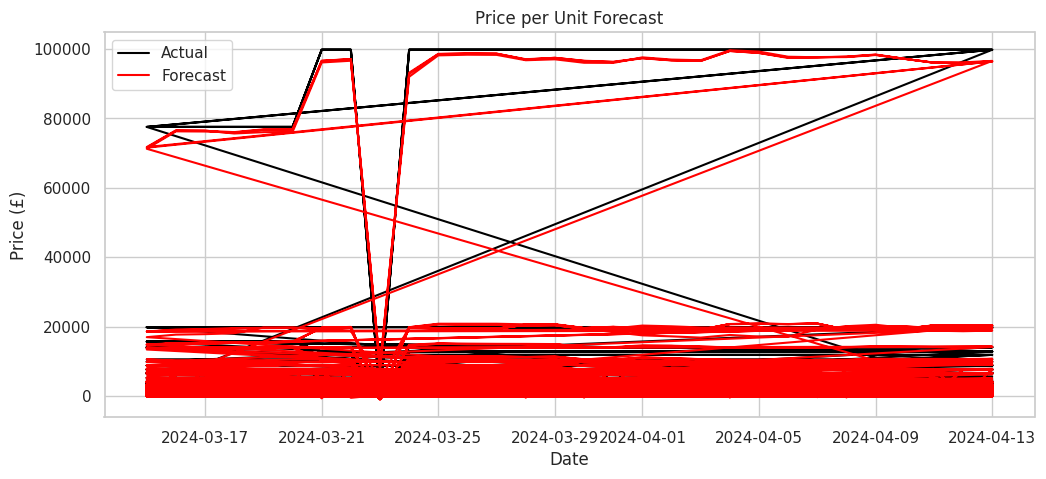

In [16]:
plt.figure(figsize=(12,5))
plt.plot(test['date'], y_test, label='Actual', color='black')
plt.plot(test['date'], y_pred, label='Forecast', color='red')
plt.title("Price per Unit Forecast")
plt.xlabel("Date")
plt.ylabel("Price (£)")
plt.legend()
plt.show()

In [17]:
results = test.copy()
results['y_true'] = y_test.values
results['y_pred'] = y_pred

print(results[['y_true', 'y_pred']].describe().T)


           count       mean         std          min       25%       50%  \
y_true  979800.0  61.334575  987.988458     0.000000  4.200000  7.500000   
y_pred  979800.0  62.020841  977.742576 -1004.049451  4.320546  7.526781   

             75%           max  
y_true  13.10000  99778.000000  
y_pred  13.52496  99626.917978  


In [18]:
import joblib
joblib.dump(best_model, '/kaggle/working/best_model.pkl')

['/kaggle/working/best_model.pkl']

## SMAPE

In [19]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return np.mean(diff) * 100

smape_val = smape(y_test, y_pred)
print(f"Test SMAPE: {smape_val:.2f}%")

Test SMAPE: 9.68%
